In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda
import glob
import metpy
from metpy import calc
from metpy.units import units
from scipy import stats

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [105]:
pregion = 'southern'
#inpath = '/media/ck/Elements/SouthAmerica/ERA5/hourly/'+pregion+'_cross_15UTC_1985-2018_peru.nc'
inpath = '/media/ck/Elements/SouthAmerica/ERA5/hourly/'+pregion+'_perpendicular_15UTC_1985-2018_peru.nc'

In [106]:
dry_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/dry_spells_1mm_3-7days_StartOfSpell.nc')
wet_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/wet_spells_1mm_3-7days_StartOfSpell.nc')
dry_test.name = 'dry'
wet_test.name = 'wet'

In [107]:
ds = xr.open_dataset(inpath)

In [108]:
ds = ds.assign_coords({'index' : ds.longitude})

In [109]:
ds = ds.drop('longitude')

In [110]:
ds = ds.rename({'index' : 'longitude'})

In [111]:
ds

<xarray.Dataset>
Dimensions:    (level: 17, longitude: 100, time: 6092)
Coordinates:
  * level      (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
  * time       (time) datetime64[ns] 1986-03-23 1986-11-18 ... 2017-10-08
    latitude   (longitude) float64 ...
  * longitude  (longitude) float64 -73.5 -73.38 -73.26 ... -62.22 -62.11 -62.0
Data variables:
    d          (time, level, longitude) float64 ...
    z          (time, level, longitude) float64 ...
    r          (time, level, longitude) float64 ...
    q          (time, level, longitude) float64 ...
    t          (time, level, longitude) float64 ...
    u          (time, level, longitude) float64 ...
    v          (time, level, longitude) float64 ...
    w          (time, level, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-01 09:26:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [112]:
regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-18,-12)]}
h = 2000

In [113]:
region = pregion
spell_length = 3
alls = regions[region]

In [114]:
topo_full = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/ERA5_static_hourly_0.25deg_peru.nc')
topo_full = uda.flip_lat(topo_full)

In [115]:
height = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc')
hei = height['h'].sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()
hei_perp = hei[0:100].copy(deep=True)

In [116]:
hei_val = []
for hin in ds.longitude:

    hind = ds.sel(longitude=hin)
    point = height.sel(latitude=hind.latitude, longitude=hind.longitude, method='nearest')
    hei_val.append(point)
height_perp = xr.concat(hei_val, dim='longitude')

In [117]:
z_val = []
for hin in ds.longitude:

    hind = ds.sel(longitude=hin)
    point = topo_full.sel(latitude=hind.latitude, longitude=hind.longitude, method='nearest')
    z_val.append(point)
z_perp = xr.concat(z_val, dim='longitude')

In [118]:
z_perp = z_perp.assign_coords({'longitude' : ds.longitude}).squeeze()
height_perp = height_perp.assign_coords({'longitude' : ds.longitude}).squeeze()

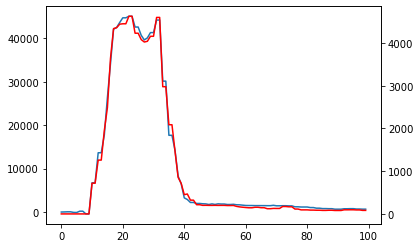

In [119]:
f = plt.figure()
ax = f.add_subplot(111)
ax1 = ax.twinx()
ax.plot(z_perp['z'])
ax1.plot(height_perp['h'], color='red')

In [120]:
dummy = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/*.nc')[0]).isel(time=0, level=0)
dummy = uda.flip_lat(dummy)

In [121]:
dry = dummy.salem.transform(dry_test, interp='nearest').where(height>=2000)
wet = dummy.salem.transform(wet_test, interp='nearest').where(height>=2000)

In [122]:
ds_filtered = ds.drop('latitude')

In [123]:
ds_filtered = ds_filtered.load()

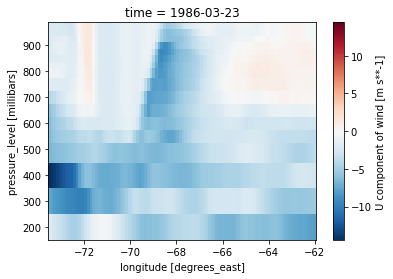

In [124]:
ds_filtered['u'].isel(time=0).plot()

In [125]:
ds_filtered = ds_filtered.where(ds['z']>z_perp['z'])

In [126]:
ds_filtered = ds_filtered.sel(time=ds_filtered['time.year']>=2000)

In [127]:
def get_spells(spell_ds,alls,spell_length,era_times, equal=None, gt=None):
    
    mask = 0
    if gt is not None:
        mask = spell_ds >= spell_length
    if equal is not None:
        mask = spell_ds == spell_length
    
    #ipdb.set_trace()
    dry_region = spell_ds['h'].sel(latitude=slice(alls[0][0], alls[0][1])).where(mask).count('latitude').squeeze()
    dry_region_all = spell_ds['h'].sel(latitude=slice(alls[0][0], alls[0][1])).where(np.isfinite(spell_ds)).count('latitude').squeeze()
    #ipdb.set_trace()
    dry_dates = dry_region.where((dry_region.mean(['longitude'])/dry_region_all.mean(['longitude'])>0.15), drop=True)  # fraction covered by spell, 0.25 means 25% of pixels on day
    
    drydates = []
    for edates in era_times:
        dpos = np.where(edates.values == dry_dates.time.values)
        #ipdb.set_trace()
        if np.sum(dpos)>0:
            #ipdb.set_trace()
            drydates.append(pd.Timestamp(dry_dates.time.values[dpos][0]))
    return pd.to_datetime(drydates)

In [94]:
drydates = get_spells(dry,alls,3,ds_filtered.time, equal=True)

In [95]:
wetdates = get_spells(wet,alls,3,ds_filtered.time, equal=True)

In [96]:
drydates7 = get_spells(dry,alls,5,ds_filtered.time, gt=True)

In [97]:
wetdates7 = get_spells(wet,alls,5,ds_filtered.time, gt=True)

In [98]:
def draw_cross(ax, data, lon, lat, title=None, xlabel=None, ylabel=None,  cmap=None,mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, cbar=True,**kwargs):

    mapp = ax.contourf(lon, lat, data, extend='both', alpha=0.8, cmap=cmap, **kwargs)  # this is the actual plot
    
#     cmapp = uplot.discrete_cmap(25, base_cmap=cmap)
#     mapp = ax.pcolormesh(lon, lat,data,cmap=cmapp, vmin=50, vmax=68)
    ax.set_ylim(170,1000)
    #ax.set_xlim(-81.5,-60)
   # ax.set_xlim(-81.5,-72.5)
    # Adjust the y-axis to be logarithmic
    #ax.set_yscale('symlog')
    #ax.set_yticklabels(np.arange(1000, 50, -100))
    
    #ax.set_yticks(np.arange(1000, 50, -100))
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'], width=0.002, headwidth=7)
#         qk = plt.quiverkey(qu, 0.45, 0.52, 1, '1 m s$^{-1}$ | ',
#                            labelpos='E', coordinates='figure')
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors=contour['colours'], linewidths=1.7, linestyles='solid' )
        plt.clabel(cs, inline=1, fontsize=8, fmt='%1.0f')  #, fmt='%1.1f'
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if cbar:
        cbar = plt.colorbar(mapp, pad=0.09, format='%1.1f')  # adds colorbar '%d'
        #cbar = plt.colorbar(mapp, ticks=np.linspace(50,68,25), pad=0.09)
        cbar.set_label(cbar_label)
    
    #return mapp

In [99]:
dds = drydates #-pd.Timedelta('1days')
wds = wetdates #-pd.Timedelta('1days')
dds7 = drydates7 #-pd.Timedelta('1days')
wds7 = wetdates7# -pd.Timedelta('1days')

slices_dry = ds_filtered.sel(time=dds).mean('time')
slices_wet = ds_filtered.sel(time=wds).mean('time')
sli_dry = ds_filtered.sel(time=dds)#.mean('time')
sli_wet = ds_filtered.sel(time=wds)#.mean('time')

In [100]:
slices_all_dryclim = ds_filtered.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds.dayofyear)).mean('dayofyear')
slices_all_wetclim = ds_filtered.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds.dayofyear)).mean('dayofyear')
slices_all_dryclim7 = ds_filtered.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds7.dayofyear)).mean('dayofyear')
slices_all_wetclim7 = ds_filtered.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds7.dayofyear)).mean('dayofyear')

slices_all = ds_filtered.mean('time')
sli_all = ds_filtered

In [101]:
slices_dry7 = ds_filtered.sel(time=dds7).mean('time')
slices_wet7 = ds_filtered.sel(time=wds7).mean('time')
sli_dry7 = ds_filtered.sel(time=dds7)#.mean('time')
sli_wet7 = ds_filtered.sel(time=wds7)#.mean('time')

In [102]:
slices_months = [('3 dry',slices_dry, sli_dry, slices_all_dryclim), ('3 wet',slices_wet, sli_wet, slices_all_wetclim), ('>5 dry', slices_dry7, sli_dry7, slices_all_dryclim7), ('>5 wet', slices_wet7, sli_wet7, slices_all_wetclim7)]

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: The following kwargs were not used by contour: 'linewidth'


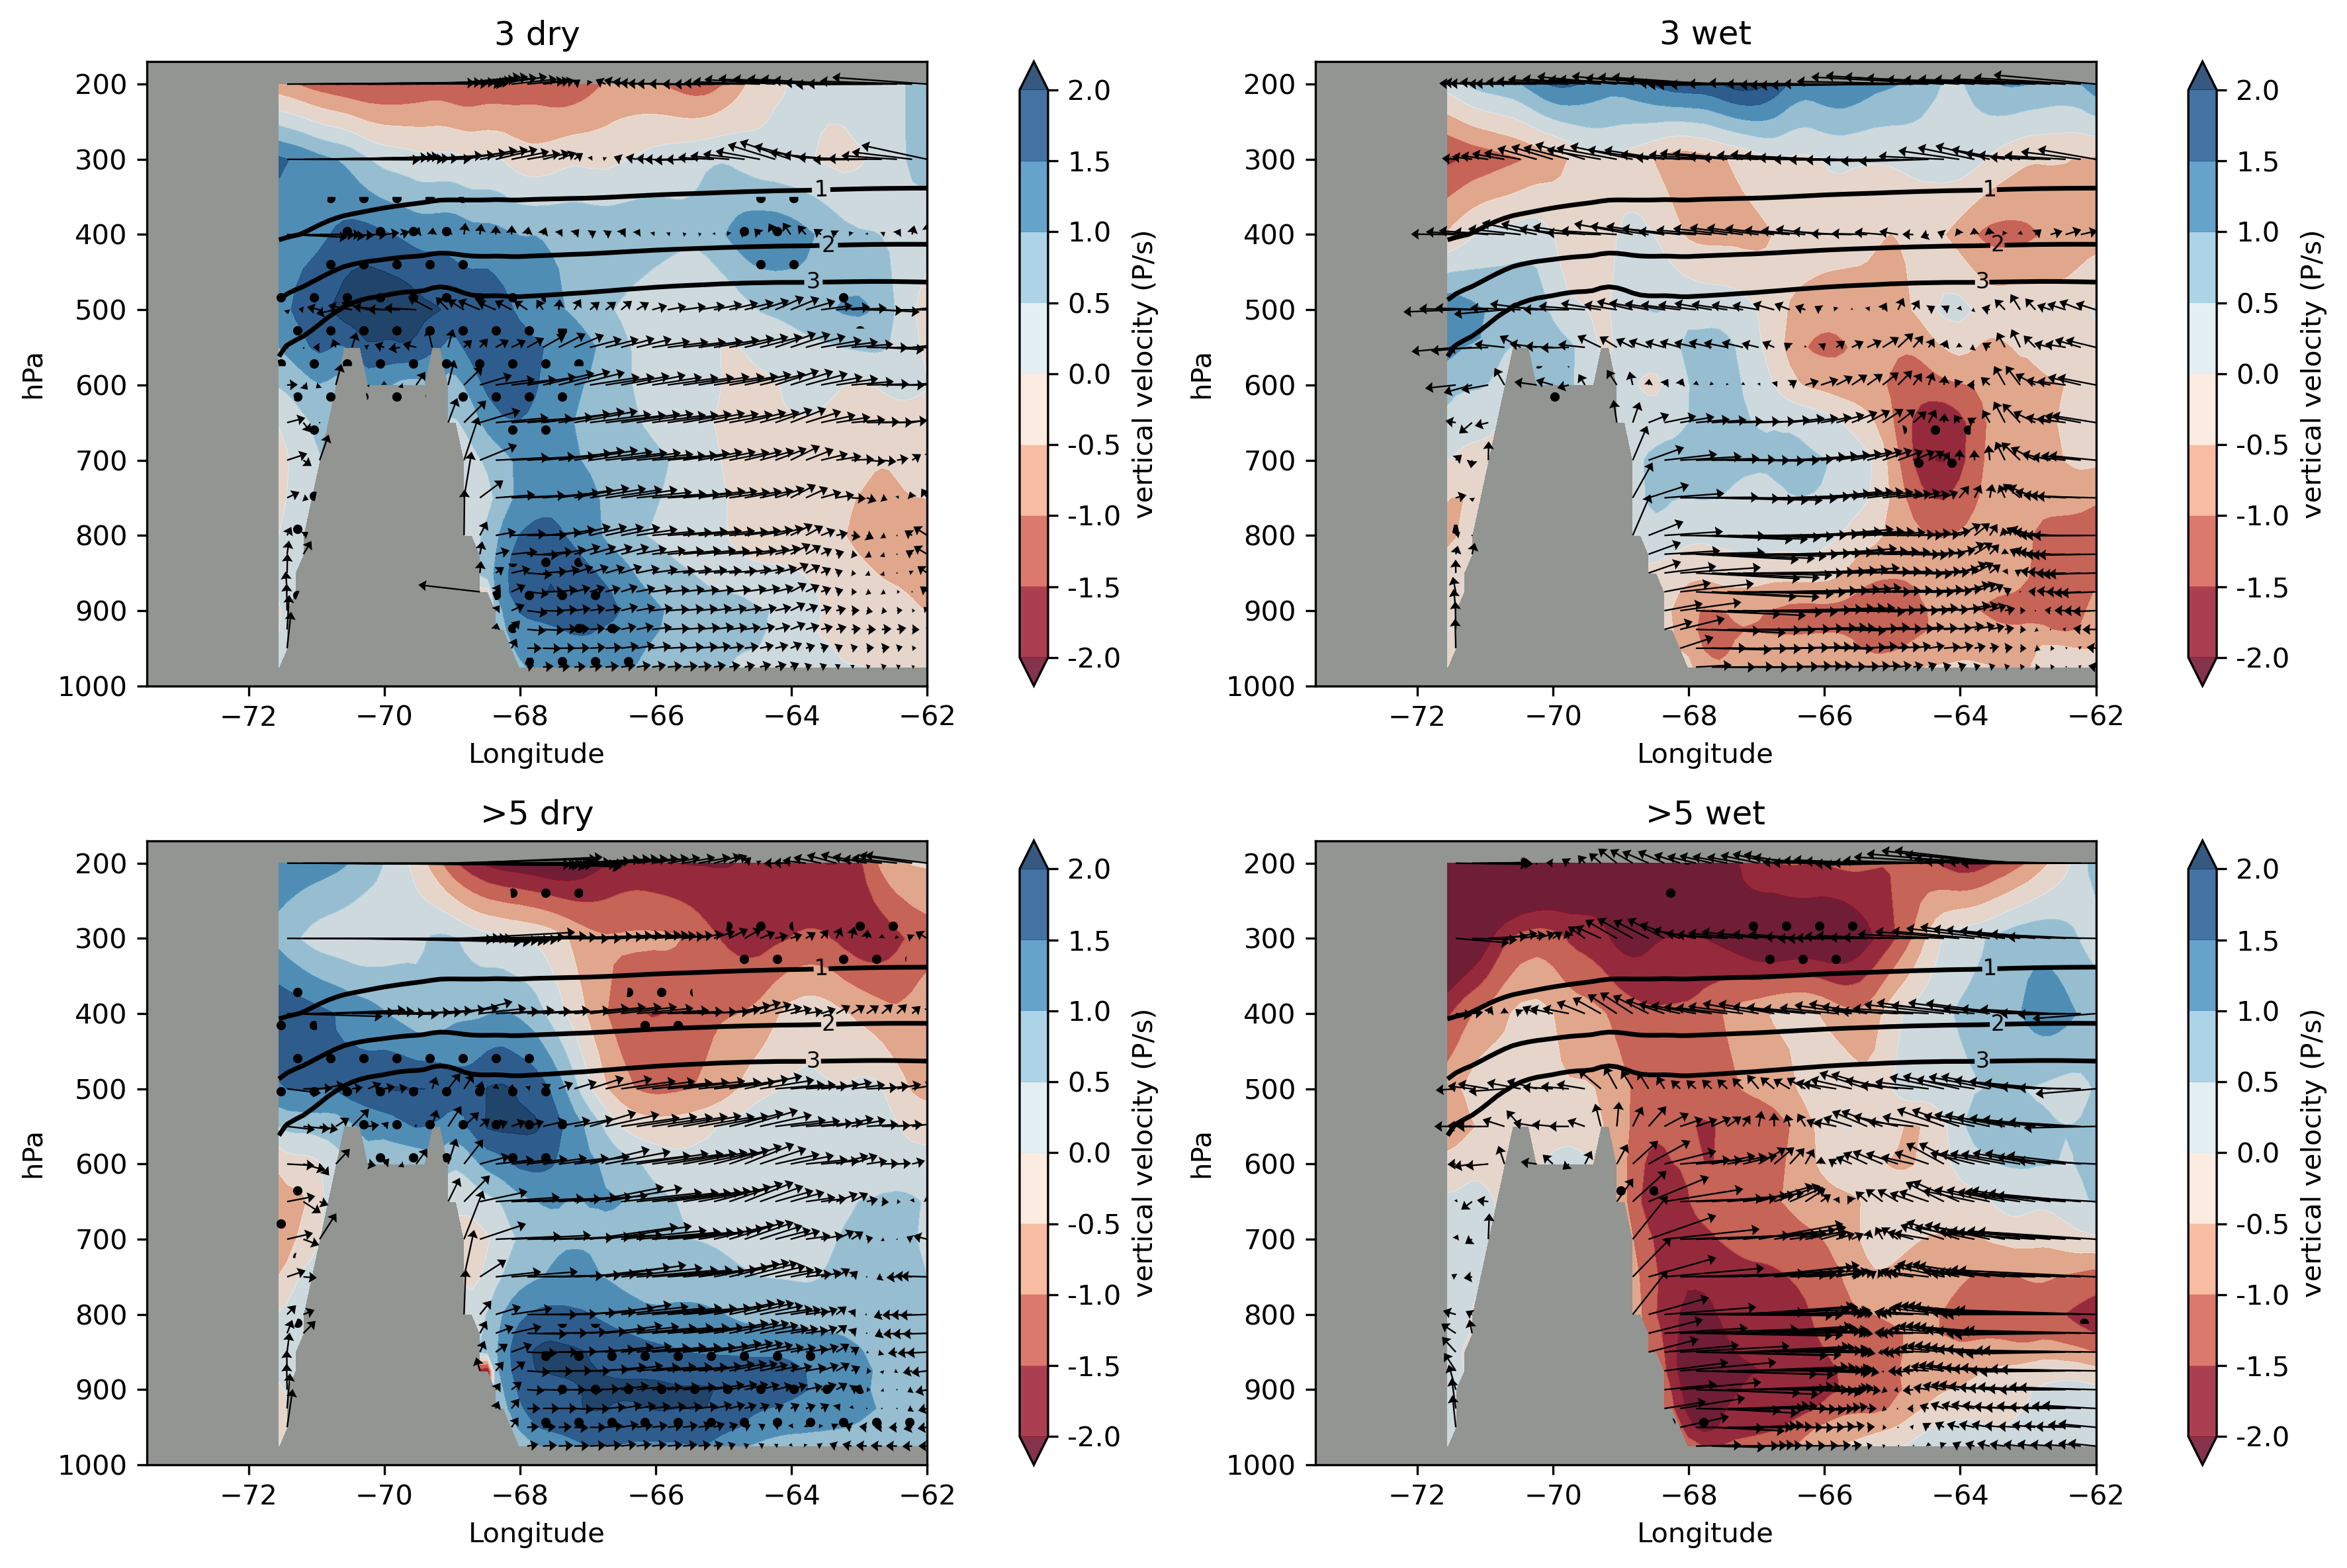

In [104]:
f = plt.figure(figsize=(12,8), dpi=300)

for ids, tt in enumerate([11,12,1,3,]):
    
    slices = slices_months[ids][1]
    tag = slices_months[ids][0]
    sli = slices#.isel(month=())
    slices_ttest = slices_months[ids][2]
    slice_clim = slices_months[ids][3]

#     p = units.Quantity(sli.level.values, 'hPa')

#     t = units.Quantity(sli['t'].values, 'K')
#     q = units.Quantity(sli['q'].values, 'kg/kg')


#     dewp = calc.dewpoint_from_specific_humidity(q.T, t.T, p).T
#     theta_e = calc.equivalent_potential_temperature(p,t.T,dewp.T).T
#     theta = calc.potential_temperature(p,t.T).T

    # "current zonal wind" wind vectors
    vano = sli['u']
    wano = sli['w']*(-5)  # multiplied by 10 since vertical component is very small compared to horizontal one
    vclim = slices_all['u']
    wclim = slices_all['w']*(-5)
    st=2
    sarrow = 1
    xquiv = sli.longitude[sarrow::st]
    yquiv = sli.level

    uu = (vano)[::, sarrow::st]  
    ww = (wano)[::, sarrow::st]
    uuc = (vclim)[::, sarrow::st]  
    wwc = (wclim)[::, sarrow::st]  

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 40}

    # temperature and moisture check
    #data = (np.array(theta.data).T-np.nanmean(theta.data, axis=1)).T
    var = 'v'
    a = slices_ttest[var] #* slices_ttest['q']
    b = sli_all[var] #* sli_all['q']
    tstat, pval = stats.ttest_ind(a, b, axis=0)
    mask = pval<=0.05
    data2 = (slices[var]-slices_all[var])#*1000#-slices_all[var])*1000#*1000#*10#00 -slices_all['w']  #-slices_all['v']-slices_all[var]
    #ipdb.set_trace()
    data = slices_all['q']*1000
    ax = f.add_subplot(2,2,ids+1)
    
    contour = {'data' : data, 'x' :sli.longitude, 'y' : sli.level, 'levels' : np.arange(-3,3.1), 'colours' : 'k'}
    draw_cross(ax, data2, sli.longitude, sli.level, ylabel = 'hPa', xlabel='Longitude',cmap='RdBu', quiver=qin, contour=contour, cbar_label='vertical velocity (P/s)', levels=np.arange(-2,2.05, 0.5), title=tag)  #Spectral
    
    ax.contourf(sli.longitude, sli.level, mask, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    ax.set_facecolor('xkcd:grey')
    plt.tight_layout()
    f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/correlations/cross/'+var+'_drywet_perpendicular_'+pregion+'_DoyClim.jpg')
